In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline

## Read in RV data for HD 17156 b

In [14]:
rv_data = astropy.io.ascii.read("UID_0108859_RVC_002.tbl.txt", format='ipac')

## Plot the best-fit model

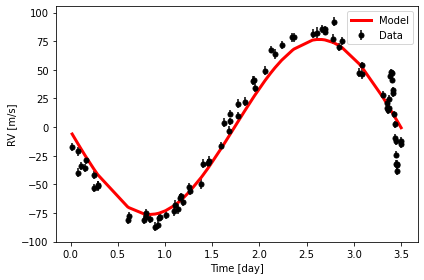

In [44]:
t = rv_data["HJD"].data
if True:
    import JW_lib
    orbital_solution = [3.52474859, 2452854.825415, 0.014, 83, 76.4]
    rv = JW_lib.RadialVelocity(orbital_solution)
    # The parameters are period, time at periastron, eccentricity, argument of periastron, RV semi-amplitude

    # Calculate model RVs
    rvs = rv.rv_drive(t)
else:
    import radvel
    orbital_solution = [3.52474859, 2452854.825415, 0.014, 121.36 / 360.0 * 2 * np.pi, 275.6]
    rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = 3.52474859

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.errorbar(rv_data["HJD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)
plt.legend()
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()

## Read in transit data for HD 17156 b

In [1]:
tr_data = astropy.io.ascii.read("UID_0108859_PLC_005.tbl.txt", format='ipac')
# tr_data = astropy.io.ascii.read("/Users/wang.12220/Downloads/UID_0013192_PLC_010.tbl.txt")
# tr_data = astropy.io.ascii.read("/Users/wang.12220/Downloads/1315925044.txt")


NameError: name 'astropy' is not defined

## Calculate the best-fit model

In [46]:
import pylightcurve as plc

# best-fit parameters from ExoFast
#planet, stellar_logg, stellar_temperature, stellar_metallicity, rp_over_rs, \
#fp_over_fs, period, sma_over_rs, eccentricity, inclination, periastron, mid_time = \
#"HD 209458 b", 4.192, 6071, 0.0, 0.11532, 2.4367028655531474e-07, \
#3.52474859, 23.428833, 0.014, 86.1, 2452854.825415, 2454438.483466

planet = plc.get_planet('hd209458b')   ## Use this to get all the data for the star without manually entring everything


time_array = tr_data["HJD"].data
# time_array = tr_data["col1"].data

# Calculate Limb-darkening parameters
#limb_darkening_coefficients = plc.clablimb('claret', stellar_logg, stellar_temperature, 
#                                               stellar_metallicity, 'V')

# Calculate transiting light curve
#flux_array = plc.transit_integrated('claret', limb_darkening_coefficients, rp_over_rs, period, sma_over_rs, 
#                                        eccentricity, inclination, periastron, mid_time, time_array, 120, 120, 
#                                        precision=6)

# If the above report errors, comment out the above lines, try change False to True, and run the following:
if True:
    planet = plc.get_planet('hd209458b')   ## Use this to get all the data for the star without manually entring everything

    time_array = tr_data["HJD"].data
    #time_array = tr_data["col1"].data

    # Calculate Limb-darkening parameters
    limb_darkening_coefficients = planet.filter('COUSINS_R').limb_darkening_coefficients  ## New way to gt the coeffs

    flux_array = planet.transit_integrated(time_array, time_format='BJD_TDB', 
                                           exp_time=120, time_stamp = 'mid', filter_name='COUSINS_R', max_sub_exp_time=1)

Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.


## Plot the best-fit model

In [47]:
tr_data.colnames

['HJD', 'Relative_Flux', 'Relative_Flux_Uncertainty', 'Accepted']

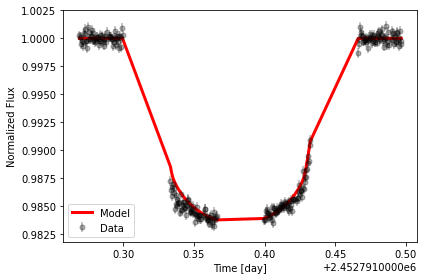

In [48]:
plt.errorbar(tr_data["HJD"], tr_data["Relative_Flux"], tr_data["Relative_Flux_Uncertainty"], ms=5, \
             marker="o", ls="none", label="Data", color="black", alpha=0.3)

# flx = 2.512**(-tr_data["col2"])
# flx = flx / np.median(flx)
# plt.plot(tr_data["col1"], flx , ms=5, \
#              marker="o", ls="none", label="Data", color="black", alpha=0.3)

plt.plot(time_array, flux_array, 'r-', lw=3, label="Model")
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

In [49]:
# (planet, stellar_logg, stellar_temperature, stellar_metallicity, rp_over_rs, fp_over_fs, 
#      period, sma_over_rs, eccentricity, inclination, periastron, mid_time) = plc.find_oec_parameters('hd17156b')

## Fitting RV data for HD 17156 b

In [50]:
import scipy.signal as signal
x = rv_data["HJD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]


## Finding the periodicity in the data

In [51]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

Text(0, 0.5, 'Power')

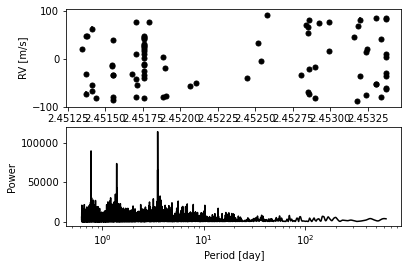

In [52]:
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [HJD]")
plt.ylabel("RV [m/s]")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")

In [53]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  3.5246452355396656  day


## Now gather information for orbital solution from references, we are ready for MCMC, which gives uncertainties for best-fit parameters.



## Define a model function with five parameters: 

## period (day), time at periastron (MJD), eccentricity, argument of periastron (degree), RV amplitude (m/s)

In [54]:
 def calcModel(params, t_stamp=None):
     per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
     rv = JW_lib.RadialVelocity([per, t0, ecc, omega, rv_amp])
     return(rv.rv_drive(t_stamp))

#def calcModel(params, t_stamp=None):
 #   per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
  #  return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))

## Define prior function 

In [55]:
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable
#planet_name = "HD 17156 b"
planet_name = "HD 209458 b"

if planet_name == "HD 209458 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 2, 4)
    log_priors['t0']           = lambda x: a_b_range(x, 2451341, 2453371)
    log_priors['ecc']           = lambda x: a_b_range(x, 0.01, .02)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 100.)
    log_priors['K']           = lambda x: a_b_range(x, 50., 500.)
    t_stamp      = rv_data["HJD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = [3.52474859, 2452854.825415, 0.014, 83, 76.4]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "HD 209458 b" or "Teegarden b" """)

## Define likelihood function 

In [56]:
def calc_log_prob(params, data, data_errors, params_keys=params_keys, params_fixed=params_fixed, \
                  params_fixed_keys=params_fixed_keys, t_stamp=t_stamp, plot_flag=False):
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = params[i]

    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]

    # Prior calculation of all input parameters
    log_prior = 0.

    for key in params_keys:
        if not(type(params_dic[key]) is list):
            log_prior += log_priors[key](params_dic[key])
        else:
            for val in params_dic[key]:
                log_prior += log_priors[key](val)

    # Return -inf if parameters fall outside prior distribution
    if (log_prior == -np.inf):
        return -np.inf
    
    # Calculate the log-likelihood
    log_likelihood = 0.

    # Calculate the forward model, this
    # returns the wavelengths in um and flux in W/m2

    rv_model = calcModel(params_dic, t_stamp=t_stamp)

    if plot_flag:
        plt.plot(t_stamp, rv_model, "k^-", alpha=0.5, label="model")
        plt.plot(t_stamp, data, "rx-", alpha=0.5, label="data")
        plt.xlabel("Time [BJD]")
        plt.ylabel("RV [m/s]")
        plt.legend()
        plt.show()

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(rv_model)) > 0:
        print("NaN spectrum encountered")
        return -np.inf

    # Calculate log-likelihood
    log_likelihood += -np.sum(((rv_model - data)/ \
                       data_errors)**2.)/2.

    if np.isnan(log_prior + log_likelihood):
        return -np.inf
    else:
        return log_prior + log_likelihood

## Test: calculate likelihood function

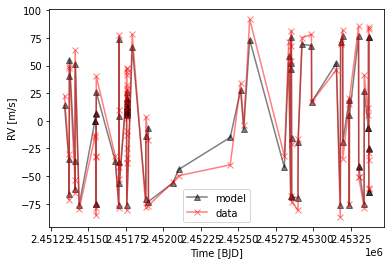

-897.0161394174288


In [57]:
print(calc_log_prob(params, data, data_errors, plot_flag=True))

## Now MCMC

In [58]:
import emcee

In [59]:
per = params[0]; e_per = 0.01
t0 = params[1]; e_t0 = 0.05
ecc = params[2]; e_ecc = 0.01
omega = params[3]; e_omega = 0.1
K = params[4]; e_K = 0.1


p_0 = params
e_p = [e_per, e_t0, e_ecc, e_omega, e_K]


ndim, nwalkers, nruns = len(p_0), 200, 1000
pos = [p_0 + e_p*np.random.randn(ndim) for i in range(nwalkers)]

import time as timer
start = timer.time()

from multiprocessing import Pool

# if pool works then use True, this option will use multi thread to increase computaional speed. Otherwise use False.
if False: 
    with Pool() as pool:

        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors), pool=pool, threads=5)
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))
else:
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors))
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))

C:\Users\jonbe\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


MCMC took 919.4 seconds


## Check MCMC result

In [1]:
samples = sampler.chain[:, 1:, :].reshape((-1, ndim))[0:-1:10, :]


print("flat chain shape: {0}".format(samples.shape))


NameError: name 'sampler' is not defined

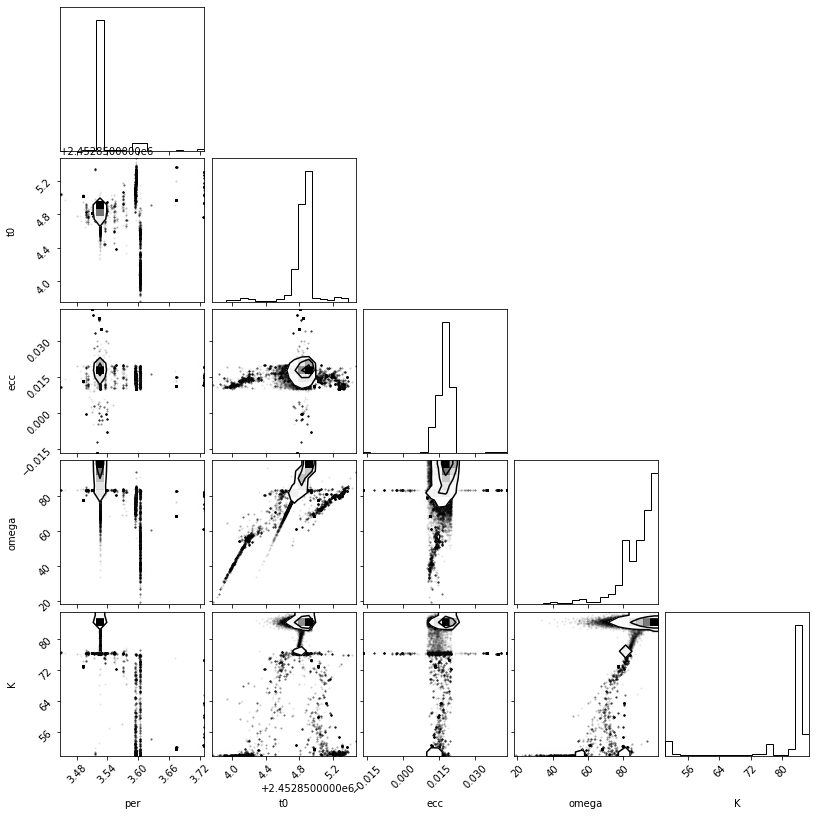

In [65]:
import corner
fig = corner.corner(samples, labels=params_keys, plot_contours=True)

## Plot models with data

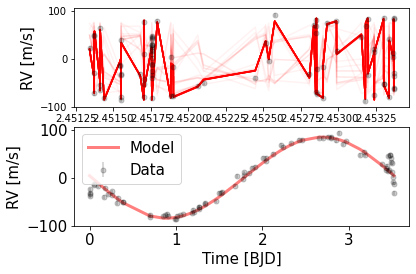

In [66]:
fig, ax = plt.subplots(2,1)

inds = np.random.randint(len(samples[:,0]), size=100)
for ind in inds:
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = samples[ind,:][i]        
    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]
    #print(params_dic["logg"])
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
    ax[0].plot(t_stamp, rv_model, 'r', alpha=0.05,label='_nolegend_')
    
    
ax[0].errorbar(t_stamp, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[0].plot(t_stamp, rv_model, "r", alpha=0.5, label="Model")


# Getting median values
values = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
params = np.array(list(values))[:,0]
params_fixed = []
params_dic = {}
for i, key in enumerate(params_keys):
    params_dic[key]       = params[i]
for i, key in enumerate(params_fixed_keys):
    params_dic[key]       = params_fixed[i]


rv_model = calcModel(params_dic, t_stamp=t_stamp)
per = params_dic["per"]
ind1 = np.argsort(t_stamp % per)
ax[1].errorbar(t_stamp % per, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[1].plot((t_stamp % per)[ind1], rv_model[ind1], "r", alpha=0.5,label='Model', lw=3)

ax[1].set_xlabel("Time [BJD]", fontsize=15)
ax[0].set_ylabel("RV [m/s]", fontsize=15)
ax[1].set_ylabel("RV [m/s]", fontsize=15)

plt.gca().tick_params(labelsize=15)
ax[1].legend(fontsize=15)
# plt.tight_layout()
# plt.savefig("model_data.png")

In [67]:
print(limb_darkening_coefficients)

[0.38053152064099915, 0.15572055172934288, 0.3873949129013969, -0.23676394656438396]


In [1]:
P = 304529.348350627115 # s # Period
K = 80 # m/s +/- 6.08 m/s
a = 7.1 * 10 ** 9 # m # semi-major axis
Ms = 2.2 * 10 ** 30 # kg +/- .040 * 10 ** 30 kg # Star mass
Mp = 1.253 * 10 ** 27 # kg +/- .152 * 10 ** 27 kg # Planet mass
Rm = 9.898 * 10 ** 7 # m +/- .502 * 10 ** 7 m # Planet radius
Rs = 8.37 * 10 ** 8 # m +/- .424 * 10 ** 8 m # Star radius
P = 310.937 # kg/m ** 3 +/- 41.355 kg/m ** 3 # Planet density
D = .175